In [1]:
#%% Imports

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from networkx import DiGraph
import networkx as nx
import statistics
from itertools import permutations
from itertools import combinations #no longer being used
from IPython import display

In [2]:
curated = pd.read_csv('curated_gene_disease_associations.tsv', sep = "\t")
curated

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.700,0.538,C0019209,Hepatomegaly,phenotype,C23;C06,Finding,0.30,1.000,2017.0,2017.0,1,0,CTD_human
1,1,A1BG,0.700,0.538,C0036341,Schizophrenia,disease,F03,Mental or Behavioral Dysfunction,0.30,1.000,2015.0,2015.0,1,0,CTD_human
2,2,A2M,0.529,0.769,C0002395,Alzheimer's Disease,disease,C10;F03,Disease or Syndrome,0.50,0.769,1998.0,2018.0,3,0,CTD_human
3,2,A2M,0.529,0.769,C0007102,Malignant tumor of colon,disease,C06;C04,Neoplastic Process,0.31,1.000,2004.0,2019.0,1,0,CTD_human
4,2,A2M,0.529,0.769,C0009375,Colonic Neoplasms,group,C06;C04,Neoplastic Process,0.30,1.000,2004.0,2004.0,1,0,CTD_human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84033,109580095,HBB-LCR,0.743,0.115,C0002875,Cooley's anemia,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84034,109580095,HBB-LCR,0.743,0.115,C0005283,beta Thalassemia,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84035,109580095,HBB-LCR,0.743,0.115,C0019025,Hemoglobin F Disease,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84036,109580095,HBB-LCR,0.743,0.115,C0085578,Thalassemia Minor,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human


In [3]:
threeCol = curated.drop(columns = ['diseaseType', 'DSI', 'DPI', 'diseaseClass', 'diseaseSemanticType', 'score', 'EI', 'YearInitial', 'YearFinal', 'NofPmids', 'NofSnps'])
threeCol

,geneId,geneSymbol,diseaseId,diseaseName,source
0,1,A1BG,C0019209,Hepatomegaly,CTD_human
1,1,A1BG,C0036341,Schizophrenia,CTD_human
2,2,A2M,C0002395,Alzheimer's Disease,CTD_human
3,2,A2M,C0007102,Malignant tumor of colon,CTD_human
4,2,A2M,C0009375,Colonic Neoplasms,CTD_human
...,...,...,...,...,...
84033,109580095,HBB-LCR,C0002875,Cooley's anemia,CTD_human
84034,109580095,HBB-LCR,C0005283,beta Thalassemia,CTD_human
84035,109580095,HBB-LCR,C0019025,Hemoglobin F Disease,CTD_human
84036,109580095,HBB-LCR,C0085578,Thalassemia Minor,CTD_human


In [4]:
threeCol['source'] = threeCol['source'].apply(lambda x: set(x[:].split(";")))
threeColsep = pd.DataFrame([(c, tup.geneId, tup.geneSymbol, tup.diseaseId, tup.diseaseName) for tup in threeCol.itertuples() for c in tup.source])
threeColsep = threeColsep.rename(columns= {0: 'source', 1: 'geneId', 2: 'geneSymbol', 3: 'diseaseId', 4: 'diseaseName'})
threeColsep

,source,geneId,geneSymbol,diseaseId,diseaseName
0,CTD_human,1,A1BG,C0019209,Hepatomegaly
1,CTD_human,1,A1BG,C0036341,Schizophrenia
2,CTD_human,2,A2M,C0002395,Alzheimer's Disease
3,CTD_human,2,A2M,C0007102,Malignant tumor of colon
4,CTD_human,2,A2M,C0009375,Colonic Neoplasms
...,...,...,...,...,...
96920,CTD_human,109580095,HBB-LCR,C0002875,Cooley's anemia
96921,CTD_human,109580095,HBB-LCR,C0005283,beta Thalassemia
96922,CTD_human,109580095,HBB-LCR,C0019025,Hemoglobin F Disease
96923,CTD_human,109580095,HBB-LCR,C0085578,Thalassemia Minor


In [5]:
diseasemappings = pd.read_csv('disease_mappings.tsv', sep = '\t')
diseasemappings

,diseaseId,name,vocabulary,code,vocabularyName
0,C0018923,Hemangiosarcoma,DO,0001816,angiosarcoma
1,C0854893,Angiosarcoma non-metastatic,DO,0001816,angiosarcoma
2,C0033999,Pterygium,DO,0002116,pterygium
3,C0025517,Metabolic Diseases,DO,0014667,disease of metabolism
4,C0155862,Streptococcal pneumonia,DO,0040084,Streptococcus pneumonia
...,...,...,...,...,...
242884,C0279628,Adenocarcinoma Of Esophagus,ORDO,99976,Adenocarcinoma of the esophagus
242885,C0279626,Squamous cell carcinoma of esophagus,ORDO,99977,Squamous cell carcinoma of the esophagus
242886,C0206702,Klatskin Tumor,ORDO,99978,Klatskin tumor
242887,C0007462,Causalgia,ORDO,99994,Complex regional pain syndrome type 2


In [6]:
diseasemappings.loc[diseasemappings['diseaseId']=='C1510586']

,diseaseId,name,vocabulary,code,vocabularyName
838,C1510586,Autism Spectrum Disorders,DO,0060041,autism spectrum disorder
8434,C1510586,Autism Spectrum Disorders,DO,12849,autistic disorder
14680,C1510586,Autism Spectrum Disorders,EFO,0003756,autism spectrum disorder
14696,C1510586,Autism Spectrum Disorders,EFO,0003758,autism
21101,C1510586,Autism Spectrum Disorders,HPO,HP:0000729,Autistic behaviour
21103,C1510586,Autism Spectrum Disorders,HPO,HP:0000729,Pervasive developmental disorder
21104,C1510586,Autism Spectrum Disorders,HPO,HP:0000729,Autistic behaviors
21106,C1510586,Autism Spectrum Disorders,HPO,HP:0000729,Autistic behavior
21108,C1510586,Autism Spectrum Disorders,HPO,HP:0000729,Autism spectrum disorder
21111,C1510586,Autism Spectrum Disorders,HPO,HP:0000729,Autism spectrum disorders


In [7]:
diseasemappings = diseasemappings.drop(columns = ['vocabularyName'])
diseasemappings = diseasemappings.rename(columns = {'name': 'diseaseName'})
diseasemappings

,diseaseId,diseaseName,vocabulary,code
0,C0018923,Hemangiosarcoma,DO,0001816
1,C0854893,Angiosarcoma non-metastatic,DO,0001816
2,C0033999,Pterygium,DO,0002116
3,C0025517,Metabolic Diseases,DO,0014667
4,C0155862,Streptococcal pneumonia,DO,0040084
...,...,...,...,...
242884,C0279628,Adenocarcinoma Of Esophagus,ORDO,99976
242885,C0279626,Squamous cell carcinoma of esophagus,ORDO,99977
242886,C0206702,Klatskin Tumor,ORDO,99978
242887,C0007462,Causalgia,ORDO,99994


In [8]:
result1 = diseasemappings.merge(threeColsep)
result2 = result1[result1['vocabulary'].map(lambda d: d == 'DO')]
result2['DOID'] = ('DOID:' + (result2['code']))
result2

<ipython-input-8-ecb85bb04ea3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result2['DOID'] = ('DOID:' + (result2['code']))


,diseaseId,diseaseName,vocabulary,code,source,geneId,geneSymbol,DOID
0,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,285,ANGPT2,DOID:0001816
1,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,595,CCND1,DOID:0001816
2,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1440,CSF3,DOID:0001816
3,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1499,CTNNB1,DOID:0001816
4,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,2321,FLT1,DOID:0001816
...,...,...,...,...,...,...,...,...
3230992,C0020615,Hypoglycemia,DO,9993,CTD_human,5465,PPARA,DOID:9993
3230993,C0020615,Hypoglycemia,DO,9993,CTD_human,6648,SOD2,DOID:9993
3230994,C0020615,Hypoglycemia,DO,9993,CTD_human,6927,HNF1A,DOID:9993
3230995,C0020615,Hypoglycemia,DO,9993,CTD_human,7124,TNF,DOID:9993


In [9]:
result2.loc[result2['diseaseId']=='C1510586']

,diseaseId,diseaseName,vocabulary,code,source,geneId,geneSymbol,DOID
264049,C1510586,Autism Spectrum Disorders,DO,0060041,CTD_human,552,AVPR1A,DOID:0060041
264050,C1510586,Autism Spectrum Disorders,DO,0060041,CTD_human,627,BDNF,DOID:0060041
264051,C1510586,Autism Spectrum Disorders,DO,0060041,CTD_human,760,CA2,DOID:0060041
264052,C1510586,Autism Spectrum Disorders,DO,0060041,CTD_human,1008,CDH10,DOID:0060041
264053,C1510586,Autism Spectrum Disorders,DO,0060041,CTD_human,1106,CHD2,DOID:0060041
...,...,...,...,...,...,...,...,...
264218,C1510586,Autism Spectrum Disorders,DO,12849,CTD_human,200424,TET3,DOID:12849
264219,C1510586,Autism Spectrum Disorders,DO,12849,CTD_human,205428,DIPK2A,DOID:12849
264220,C1510586,Autism Spectrum Disorders,DO,12849,CTD_human,285175,UNC80,DOID:12849
264221,C1510586,Autism Spectrum Disorders,DO,12849,CTD_human,347731,LRRTM3,DOID:12849


In [10]:
resultDOID = result2.groupby(by = ['DOID', 'diseaseName', 'source'])['geneId'].apply(lambda x: set(x))
resultDOID = resultDOID.reset_index()
resultDOID

,DOID,diseaseName,source,geneId
0,DOID:0001816,Hemangiosarcoma,CGI,"{5335, 5787, 3845, 3791}"
1,DOID:0001816,Hemangiosarcoma,CTD_human,"{1440, 3265, 4609, 7010, 7424, 3845, 2701, 372..."
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
4,DOID:0014667,Metabolic Diseases,CTD_human,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [11]:
resultDOID.loc[resultDOID['DOID']=='DOID:0060041']

,DOID,diseaseName,source,geneId
1751,DOID:0060041,Autism Spectrum Disorders,CLINGEN,{57680}
1752,DOID:0060041,Autism Spectrum Disorders,CTD_human,"{2562, 6660, 2053, 3077, 6662, 5649, 83992, 92..."
1753,DOID:0060041,Autism Spectrum Disorders,GENOMICS_ENGLAND,"{23040, 9379, 55879, 9320, 54413, 2742, 9369}"


In [9]:
#resultDOID.loc[resultDOID['DOID']=='DOID:9252']
#resultDOID[resultDOID['diseaseName'].str.contains('Nervous')]
#isinstance(dfcombsep.iloc[0]['propagatedDOID'], str)

In [12]:
from imp import reload
import ontology
reload(ontology)

<module 'ontology' from '/mnt/ufs18/home-087/f0102402/Arun_REU/ontology.py'>

In [13]:
from ontology import Ontology

In [14]:
disease_ontology = ontology.Ontology()
disease_ontology.load("/mnt/research/compbio/krishnanlab/data/ontologies/doid.obo")

In [15]:
resultDOIDshort = resultDOID.drop(columns = 'diseaseName')
dict_of_sources = dict(iter(resultDOIDshort.groupby('source')))
dict_of_sources['CLINGEN']

,DOID,source,geneId
49,DOID:0050332,CLINGEN,"{2299, 3766}"
78,DOID:0050428,CLINGEN,{362}
103,DOID:0050429,CLINGEN,{9401}
130,DOID:0050437,CLINGEN,{3920}
141,DOID:0050439,CLINGEN,{25861}
...,...,...,...
19658,DOID:9274,CLINGEN,{2639}
19664,DOID:9274,CLINGEN,{10157}
19676,DOID:9278,CLINGEN,{383}
19681,DOID:9280,CLINGEN,{1373}


In [16]:
dict_of_sources['CLINGEN'].loc[dict_of_sources['CLINGEN']['DOID']=='DOID:0060041']

,DOID,source,geneId
1751,DOID:0060041,CLINGEN,{57680}


In [17]:
dict_of_sources

{'CGI':                DOID source                                             geneId
 0      DOID:0001816    CGI                           {5335, 5787, 3845, 3791}
 57     DOID:0050387    CGI  {8289, 7428, 4968, 4233, 2475, 7403, 6927, 724...
 1088   DOID:0050745    CGI                                {1017, 3717, 29126}
 1090   DOID:0050745    CGI  {2308, 3717, 4615, 7188, 5293, 6446, 10672, 33...
 1093   DOID:0050746    CGI                      {6850, 51366, 330, 4851, 472}
 ...             ...    ...                                                ...
 19554     DOID:9254    CGI                                             {3815}
 19587     DOID:9261    CGI                                             {7157}
 19827     DOID:9499    CGI                                      {55500, 5156}
 19846     DOID:9538    CGI  {673, 4609, 3845, 1031, 330, 7403, 51185, 2261...
 19987     DOID:9952    CGI  {10019, 3716, 3717, 3718, 1387, 64109, 10320, ...
 
 [273 rows x 3 columns],
 'CLINGEN':       

In [39]:
CLINGEN_dict = dict(zip(dict_of_sources['CLINGEN'].DOID, dict_of_sources['CLINGEN'].geneId))
CTD_human_dict = dict(zip(dict_of_sources['CTD_human'].DOID, dict_of_sources['CTD_human'].geneId))
CGI_dict = dict(zip(dict_of_sources['CGI'].DOID, dict_of_sources['CGI'].geneId))
GENOMICS_ENGLAND_dict = dict(zip(dict_of_sources['GENOMICS_ENGLAND'].DOID, dict_of_sources['GENOMICS_ENGLAND'].geneId))
UNIPROT_dict = dict(zip(dict_of_sources['UNIPROT'].DOID, dict_of_sources['UNIPROT'].geneId))
ORPHANET_dict = dict(zip(dict_of_sources['ORPHANET'].DOID, dict_of_sources['ORPHANET'].geneId))
PSYGENET_dict = dict(zip(dict_of_sources['PSYGENET'].DOID, dict_of_sources['PSYGENET'].geneId))


In [40]:
CLINGEN_prop = disease_ontology.propagate(CLINGEN_dict)
CTD_human_prop = disease_ontology.propagate(CTD_human_dict)
CGI_prop = disease_ontology.propagate(CGI_dict)
GENOMICS_ENGLAND_prop = disease_ontology.propagate(GENOMICS_ENGLAND_dict)
UNIPROT_prop = disease_ontology.propagate(UNIPROT_dict)
ORPHANET_prop = disease_ontology.propagate(ORPHANET_dict)
PSYGENET_prop = disease_ontology.propagate(PSYGENET_dict)

In [20]:
CLINGEN_dict

{'DOID:0050332': {2299, 3766},
 'DOID:0050428': {362},
 'DOID:0050429': {9401},
 'DOID:0050437': {3920},
 'DOID:0050439': {7401},
 'DOID:0050451': {781,
  783,
  3752,
  3764,
  5318,
  6324,
  6327,
  6336,
  10021,
  23171,
  55800},
 'DOID:0050453': {3912},
 'DOID:0050466': {7046},
 'DOID:0050467': {2707},
 'DOID:0050469': {673,
  3265,
  3845,
  4893,
  5500,
  5604,
  5605,
  5781,
  5894,
  5921,
  5922,
  6016,
  6237,
  6654,
  6655,
  8036,
  8216,
  22808,
  144568},
 'DOID:0050471': {5573},
 'DOID:0050473': {7840},
 'DOID:0050564': {1687, 4641, 9381},
 'DOID:0050565': {1687, 4641, 9381},
 'DOID:0050566': {1687, 4641, 9381},
 'DOID:0050569': {673,
  3265,
  3845,
  4893,
  5500,
  5604,
  5605,
  5781,
  5894,
  5921,
  5922,
  6016,
  6237,
  6654,
  6655,
  8036,
  8216,
  22800,
  22808,
  144568},
 'DOID:0050572': {4647, 10083, 23568, 25861, 64072, 65217, 124590},
 'DOID:0050631': {6567},
 'DOID:0050657': {5728},
 'DOID:0050661': {4647, 10083, 23568, 25861, 64072, 65217, 

In [21]:
CLINGEN_prop

{'DOID:0050332': {2299, 3766},
 'DOID:3426': {2299, 3766},
 'DOID:0050155': {1687,
  2200,
  2299,
  3766,
  4043,
  4641,
  4647,
  4942,
  6121,
  9364,
  9381,
  10083,
  22926,
  23568,
  25861,
  64072,
  65217,
  124590},
 'DOID:4': {34,
  35,
  37,
  38,
  58,
  59,
  70,
  71,
  94,
  191,
  215,
  275,
  291,
  362,
  383,
  435,
  445,
  472,
  538,
  540,
  549,
  580,
  617,
  633,
  641,
  657,
  673,
  675,
  686,
  701,
  781,
  783,
  785,
  845,
  916,
  999,
  1027,
  1050,
  1073,
  1111,
  1281,
  1287,
  1302,
  1352,
  1355,
  1373,
  1374,
  1376,
  1387,
  1540,
  1643,
  1674,
  1678,
  1687,
  1717,
  1738,
  1759,
  1786,
  1832,
  1834,
  1908,
  1910,
  2022,
  2068,
  2071,
  2072,
  2073,
  2108,
  2109,
  2110,
  2121,
  2131,
  2138,
  2155,
  2157,
  2158,
  2159,
  2161,
  2175,
  2176,
  2184,
  2189,
  2200,
  2201,
  2261,
  2299,
  2301,
  2316,
  2318,
  2332,
  2348,
  2395,
  2548,
  2566,
  2593,
  2625,
  2628,
  2707,
  2717,
  2719,
  2731,

In [41]:
CLINGEN = pd.DataFrame([k for k in CLINGEN_prop.items()], columns=['DOID', 'geneSet'])
CTD_human = pd.DataFrame([k for k in CTD_human_prop.items()], columns=['DOID', 'geneSet'])
CGI = pd.DataFrame([k for k in CGI_prop.items()], columns=['DOID', 'geneSet'])
GENOMICS_ENGLAND = pd.DataFrame([k for k in GENOMICS_ENGLAND_prop.items()], columns=['DOID', 'geneSet'])
ORPHANET = pd.DataFrame([k for k in ORPHANET_prop.items()], columns=['DOID', 'geneSet'])
UNIPROT = pd.DataFrame([k for k in UNIPROT_prop.items()], columns=['DOID', 'geneSet'])
PSYGENET = pd.DataFrame([k for k in PSYGENET_prop.items()], columns=['DOID', 'geneSet'])

In [42]:
CLINGEN['source'] = 'CLINGEN'
CTD_human['source'] = 'CTD_human'
CGI['source'] = 'CGI'
GENOMICS_ENGLAND['source'] = 'GENOMICS_ENGLAND'
ORPHANET['source'] = 'ORPHANET'
UNIPROT['source'] = 'UNIPROT'
PSYGENET['source'] = 'PSYGENET'

In [43]:
UNIPROT

,DOID,geneSet,source
0,DOID:0050144,{27019},UNIPROT
1,DOID:4,"{339970, 8195, 4099, 8200, 18, 19, 4117, 22, 8...",UNIPROT
2,DOID:9562,"{10309, 54919, 374407, 27019, 352909, 23639, 8...",UNIPROT
3,DOID:630,"{8195, 1540, 4613, 6663, 8200, 91147, 26123, 4...",UNIPROT
4,DOID:0060340,"{54919, 374407, 91147, 27019, 352909, 26123, 5...",UNIPROT
...,...,...,...
3301,DOID:4079,{8642},UNIPROT
3302,DOID:61,{8642},UNIPROT
3303,DOID:9883,{1756},UNIPROT
3304,DOID:9955,{1482},UNIPROT


In [44]:
CLINGEN

,DOID,geneSet,source
0,DOID:0050332,"{2299, 3766}",CLINGEN
1,DOID:3426,"{2299, 3766}",CLINGEN
2,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN
3,DOID:4,"{8192, 7168, 1027, 51204, 51206, 3081, 23568, ...",CLINGEN
4,DOID:2952,"{2299, 3766}",CLINGEN
...,...,...,...
823,DOID:9273,{445},CLINGEN
824,DOID:9274,{10157},CLINGEN
825,DOID:9278,{383},CLINGEN
826,DOID:9280,{1373},CLINGEN


In [45]:
CLINGEN.loc[CLINGEN['DOID']=='DOID:0060041']

,DOID,geneSet,source
118,DOID:0060041,{57680},CLINGEN


In [46]:
CTD_human

,DOID,geneSet,source
0,DOID:0001816,"{7424, 3265, 4609, 3845, 2701, 3725, 3791, 807...",CTD_human
1,DOID:162,"{2, 9, 10, 100499467, 8202, 12, 8204, 10004891...",CTD_human
2,DOID:0050687,"{2, 4100, 9, 10, 8202, 12, 8204, 139285, 4118,...",CTD_human
3,DOID:14566,"{2, 9, 10, 100499467, 8202, 12, 8204, 10004891...",CTD_human
4,DOID:4,"{1, 2, 9, 10, 100499467, 12, 18, 19, 21, 22, 2...",CTD_human
...,...,...,...
4575,DOID:9955,"{9752, 56136, 2697, 1482, 79595}",CTD_human
4576,DOID:9975,"{10243, 2566, 2571, 2572, 442892, 442898, 1812...",CTD_human
4577,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255...",CTD_human
4578,DOID:998,"{3123, 3117}",CTD_human


In [47]:
CGI

,DOID,geneSet,source
0,DOID:0001816,"{5335, 5787, 3845, 3791}",CGI
1,DOID:162,"{2048, 1026, 1027, 7172, 1029, 1030, 1031, 171...",CGI
2,DOID:0050687,"{2048, 4609, 6657, 1029, 1030, 1031, 2064, 206...",CGI
3,DOID:14566,"{2048, 1026, 1027, 7172, 1029, 1030, 1031, 171...",CGI
4,DOID:4,"{2048, 1026, 1027, 7172, 1029, 1030, 1031, 171...",CGI
...,...,...,...
397,DOID:9499,"{55500, 5156}",CGI
398,DOID:999,"{55500, 5156}",CGI
399,DOID:854,"{55500, 5156}",CGI
400,DOID:9538,"{673, 4609, 3845, 1031, 330, 7403, 51185, 2261...",CGI


In [48]:
GENOMICS_ENGLAND

,DOID,geneSet,source
0,DOID:0002116,{23299},GENOMICS_ENGLAND
1,DOID:10124,"{200576, 23299, 7045, 4166, 3850, 91851, 1296,...",GENOMICS_ENGLAND
2,DOID:0050155,"{8195, 2055, 2059, 79883, 4117, 2070, 24, 1026...",GENOMICS_ENGLAND
3,DOID:4,"{8195, 253959, 8200, 90121, 18, 19, 139285, 22...",GENOMICS_ENGLAND
4,DOID:1492,"{1024, 3074, 3075, 23554, 8195, 3078, 283652, ...",GENOMICS_ENGLAND
...,...,...,...
4028,DOID:9883,{1756},GENOMICS_ENGLAND
4029,DOID:9923,"{9969, 116931}",GENOMICS_ENGLAND
4030,DOID:9955,{2697},GENOMICS_ENGLAND
4031,DOID:9970,"{23040, 4160, 8195, 84100, 5443, 582, 583, 123...",GENOMICS_ENGLAND


In [49]:
ORPHANET

,DOID,geneSet,source
0,DOID:0050120,"{8676, 201294, 5551, 6813}",ORPHANET
1,DOID:75,"{7424, 673, 8676, 9508, 147372, 57165, 201294,...",ORPHANET
2,DOID:4,"{8192, 4099, 8200, 90121, 18, 19, 21, 139285, ...",ORPHANET
3,DOID:7,"{4099, 8200, 90121, 21, 139285, 24, 8216, 25, ...",ORPHANET
4,DOID:2914,"{4609, 1029, 54790, 4615, 3592, 3594, 359948, ...",ORPHANET
...,...,...,...
2659,DOID:9869,{229},ORPHANET
2660,DOID:988,{6530},ORPHANET
2661,DOID:61,{6530},ORPHANET
2662,DOID:9883,{1756},ORPHANET


In [50]:
PSYGENET

,DOID,geneSet,source
0,DOID:0050741,"{2052, 9, 28, 4128, 4129, 7200, 10280, 3122, 5...",PSYGENET
1,DOID:4,"{4099, 9, 19, 8214, 94233, 28, 8220, 90141, 41...",PSYGENET
2,DOID:303,"{2052, 9, 3084, 28, 4128, 4129, 7200, 10280, 3...",PSYGENET
3,DOID:9973,"{2052, 9, 3084, 28, 4128, 4129, 7200, 10280, 3...",PSYGENET
4,DOID:150,"{4099, 9, 19, 8214, 94233, 28, 8220, 90141, 41...",PSYGENET
5,DOID:0060167,"{1408, 6532, 6095, 5141, 406, 1815, 94233, 335...",PSYGENET
6,DOID:1561,"{4099, 19, 8214, 94233, 28, 8220, 90141, 4128,...",PSYGENET
7,DOID:1596,"{23040, 27136, 1029, 3589, 6662, 9734, 2571, 2...",PSYGENET
8,DOID:3324,"{1029, 9223, 2065, 3091, 5141, 94233, 28, 1027...",PSYGENET
9,DOID:0070077,"{100303453, 6999}",PSYGENET


In [51]:
propagated = CLINGEN.append(CTD_human).append(CGI).append(GENOMICS_ENGLAND).append(ORPHANET).append(UNIPROT).append(PSYGENET)
propagated

,DOID,geneSet,source
0,DOID:0050332,"{2299, 3766}",CLINGEN
1,DOID:3426,"{2299, 3766}",CLINGEN
2,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN
3,DOID:4,"{8192, 7168, 1027, 51204, 51206, 3081, 23568, ...",CLINGEN
4,DOID:2952,"{2299, 3766}",CLINGEN
...,...,...,...
44,DOID:809,"{4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...",PSYGENET
45,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET
46,DOID:9478,"{8864, 6532, 3350, 4988, 50809, 4524, 148014}",PSYGENET
47,DOID:9505,"{6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...",PSYGENET


In [52]:
propagated.sort_values(by = 'DOID')

,DOID,geneSet,source
0,DOID:0001816,"{7424, 3265, 4609, 3845, 2701, 3725, 3791, 807...",CTD_human
0,DOID:0001816,"{5335, 5787, 3845, 3791}",CGI
6,DOID:0002116,{3440},CTD_human
0,DOID:0002116,{23299},GENOMICS_ENGLAND
23,DOID:0014667,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...",CLINGEN
...,...,...,...
398,DOID:999,"{55500, 5156}",CGI
4002,DOID:999,"{3572, 3716}",GENOMICS_ENGLAND
4536,DOID:999,"{2625, 81858, 5156, 4615, 81608, 5897, 3117, 3...",CTD_human
4032,DOID:9993,{84947},GENOMICS_ENGLAND


In [53]:
resultDOID

,DOID,diseaseName,source,geneId
0,DOID:0001816,Hemangiosarcoma,CGI,"{5335, 5787, 3845, 3791}"
1,DOID:0001816,Hemangiosarcoma,CTD_human,"{1440, 3265, 4609, 7010, 7424, 3845, 2701, 372..."
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
4,DOID:0014667,Metabolic Diseases,CTD_human,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [54]:
templist = []
for index, row, in propagated.iterrows():
    if (row['DOID'] in disease_ontology.nodes):
        templist.append(disease_ontology.nodes[row['DOID']]["name"])
    else:
        templist.append("error")
propagated['diseaseName'] = templist
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:3426,"{2299, 3766}",CLINGEN,vestibular disease
2,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN,sensory system disease
3,DOID:4,"{8192, 7168, 1027, 51204, 51206, 3081, 23568, ...",CLINGEN,disease
4,DOID:2952,"{2299, 3766}",CLINGEN,inner ear disease
...,...,...,...,...
44,DOID:809,"{4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...",PSYGENET,cocaine abuse
45,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET,subacute delirium
46,DOID:9478,"{8864, 6532, 3350, 4988, 50809, 4524, 148014}",PSYGENET,postpartum depression
47,DOID:9505,"{6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...",PSYGENET,cannabis abuse


In [55]:
propagated.loc[propagated['DOID']=='DOID:0060041']

,DOID,geneSet,source,diseaseName
118,DOID:0060041,{57680},CLINGEN,autism spectrum disorder
98,DOID:0060041,"{151556, 2053, 3077, 9228, 11281, 18, 5141, 51...",CTD_human,autism spectrum disorder
90,DOID:0060041,"{23040, 50944, 9024, 4929, 7812, 55879, 7432, ...",GENOMICS_ENGLAND,autism spectrum disorder


In [56]:
propagated.loc[propagated['DOID']=='DOID:1749']

,DOID,geneSet,source,diseaseName
785,DOID:1749,{7046},CLINGEN,squamous cell carcinoma
3690,DOID:1749,"{7170, 2052, 1029, 3082, 8202, 1040, 23569, 10...",CTD_human,squamous cell carcinoma
42,DOID:1749,"{641, 3265, 3845, 4233, 7249, 7507, 2068, 7508...",CGI,squamous cell carcinoma
3539,DOID:1749,"{81704, 641, 5728}",GENOMICS_ENGLAND,squamous cell carcinoma
2930,DOID:1749,"{85443, 1029, 255239, 6795, 780, 51086, 6416, ...",UNIPROT,squamous cell carcinoma


### Writing to GMT files:

In [57]:
def write_gmt(filename, names, labels):
    with open(filename, "w") as f:
        for term in labels:
            f.write(
                "{}\t{}\t{}\n".format(
                    term, names[term], "\t".join(labels[term])
                )
            )

In [58]:
propagated.to_csv('dfcombsep2.csv', index = False)

In [59]:
df = pd.read_csv('dfcombsep2.csv')

In [60]:
df['geneSet'] = df['geneSet'].apply(lambda x: set(x[2:-2].split(", ")))
df

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{299, 376}",CLINGEN,enlarged vestibular aqueduct
1,DOID:3426,"{299, 376}",CLINGEN,vestibular disease
2,DOID:0050155,"{25861, 2200, 9381, 9364, 4647, 22926, 6121, 1...",CLINGEN,sensory system disease
3,DOID:4,"{1352, 83990, 2301, 4607, 34, 2155, 540, 11327...",CLINGEN,disease
4,DOID:2952,"{299, 376}",CLINGEN,inner ear disease
...,...,...,...,...
15857,DOID:809,"{4900, 335, 1814, 5309, 3351, 1137, 148, 1813,...",PSYGENET,cocaine abuse
15858,DOID:8645,"{3576, 3569, 1814, 531, 3976, 1813, 34, 3479, ...",PSYGENET,subacute delirium
15859,DOID:9478,"{3350, 864, 50809, 4524, 6532, 14801, 4988}",PSYGENET,postpartum depression
15860,DOID:9505,"{3084, 1815, 1133, 517, 3060, 1269, 1312, 1813...",PSYGENET,cannabis abuse


In [61]:
df.iloc[0]['geneSet']

{'299', '376'}

In [62]:
dict_of_associations = dict(iter(df.groupby('source')))

In [63]:
for source in dict_of_associations:
    write_gmt(filename = ("" + source + ".gmt"), names = (dict_of_associations[source].set_index('DOID').to_dict()['diseaseName']), 
              labels = (dict_of_associations[source].set_index('DOID').to_dict()['geneSet']))

### Making Histograms:

In [64]:
dfsep = pd.DataFrame([(c, tup.DOID, tup.source) for tup in df.itertuples() for c in tup.geneSet])
dfsep

,0,1,2
0,299,DOID:0050332,CLINGEN
1,376,DOID:0050332,CLINGEN
2,299,DOID:3426,CLINGEN
3,376,DOID:3426,CLINGEN
4,25861,DOID:0050155,CLINGEN
...,...,...,...
218407,121278,DOID:9975,PSYGENET
218408,1143,DOID:9975,PSYGENET
218409,4986,DOID:9975,PSYGENET
218410,2587,DOID:9975,PSYGENET


In [65]:
dfsep = dfsep.rename(columns= {0: 'geneId', 1: 'propagatedDOID', 2: 'source'})
SumDisease = dfsep.groupby(by = ['propagatedDOID', 'source']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Source')

In [66]:
SumDisease['Log of Counts of Genes per Disease by Source'] = np.log10(SumDisease['Counts of Genes per Disease by Source'])
SumDisease = SumDisease.sort_values(by = 'propagatedDOID')
SumDisease

,propagatedDOID,source,Counts of Genes per Disease by Source,Log of Counts of Genes per Disease by Source
3808,DOID:0001816,CGI,4,0.602060
1402,DOID:0001816,CTD_human,18,1.255273
11543,DOID:0002116,CTD_human,1,0.000000
11544,DOID:0002116,GENOMICS_ENGLAND,1,0.000000
11545,DOID:0014667,CGI,1,0.000000
...,...,...,...,...
1862,DOID:999,CTD_human,11,1.041393
5105,DOID:999,CGI,2,0.301030
5060,DOID:999,GENOMICS_ENGLAND,2,0.301030
2076,DOID:9993,CTD_human,10,1.000000


<AxesSubplot:xlabel='Counts of Genes per Disease by Source', ylabel='source'>

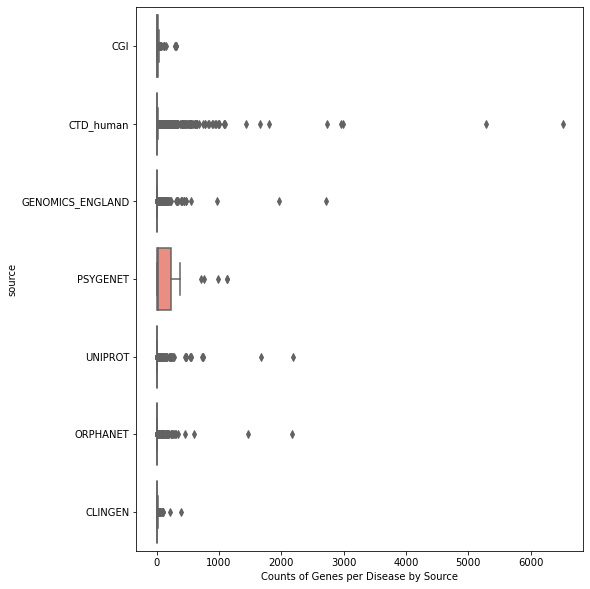

In [67]:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Counts of Genes per Disease by Source',
                 data = SumDisease, palette="Set3", orient = 'h')

<AxesSubplot:xlabel='Log of Counts of Genes per Disease by Source', ylabel='source'>

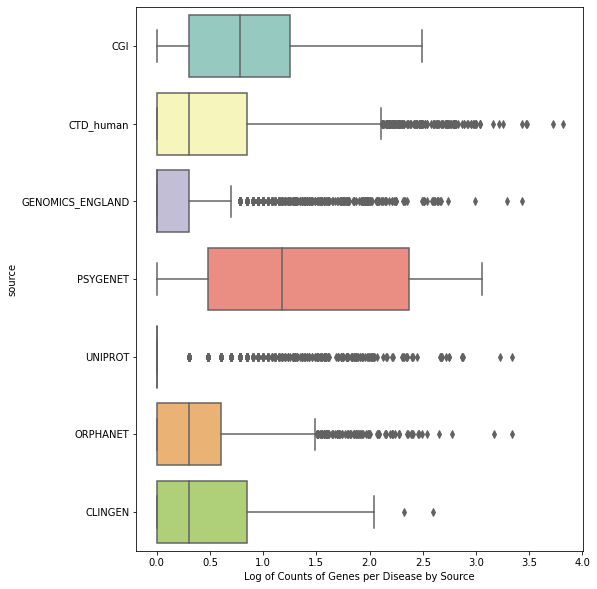

In [68]:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Log of Counts of Genes per Disease by Source',
                 data = SumDisease, palette="Set3", orient = 'h')

Text(0, 0.5, 'Frequency')

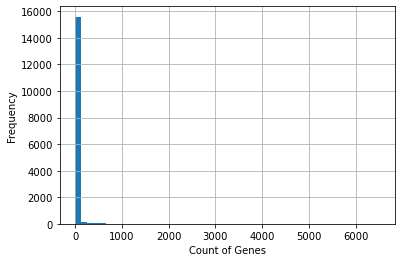

In [69]:
SumDisease['Counts of Genes per Disease by Source'].hist(bins=50)
plt.xlabel("Count of Genes", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

Text(0, 0.5, 'Frequency')

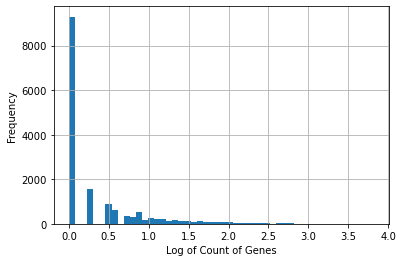

In [70]:
SumDisease['Log of Counts of Genes per Disease by Source'].hist(bins=50)
plt.xlabel("Log of Count of Genes", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

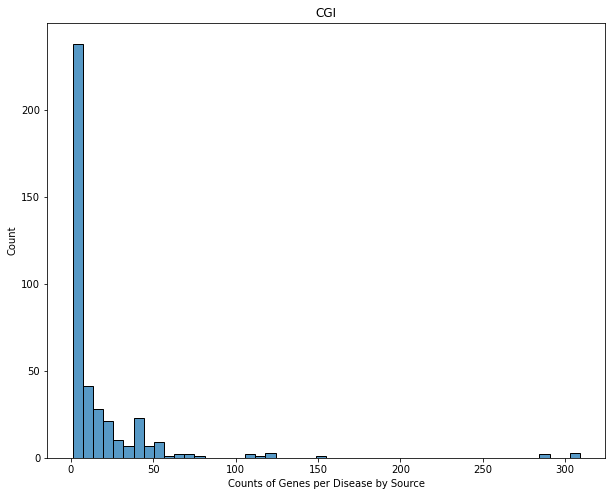

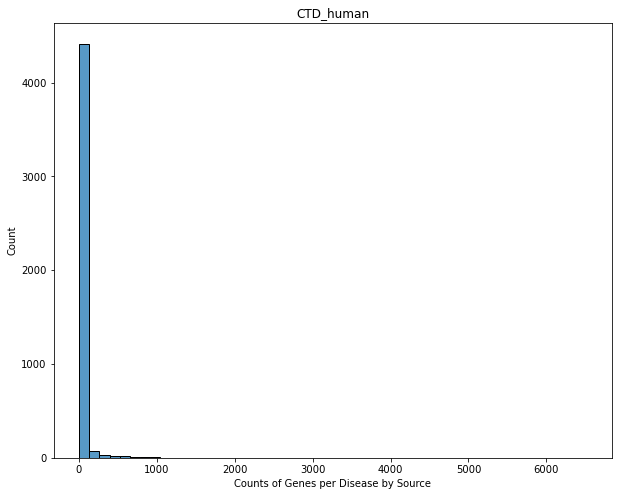

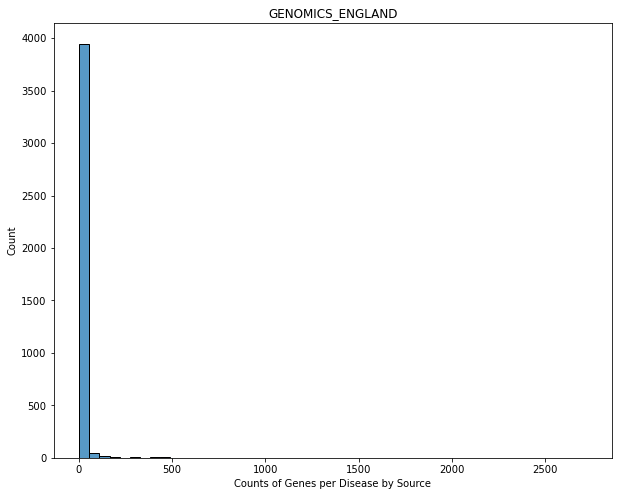

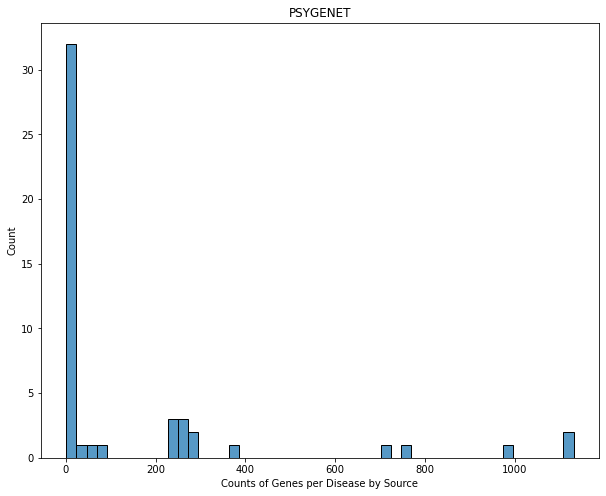

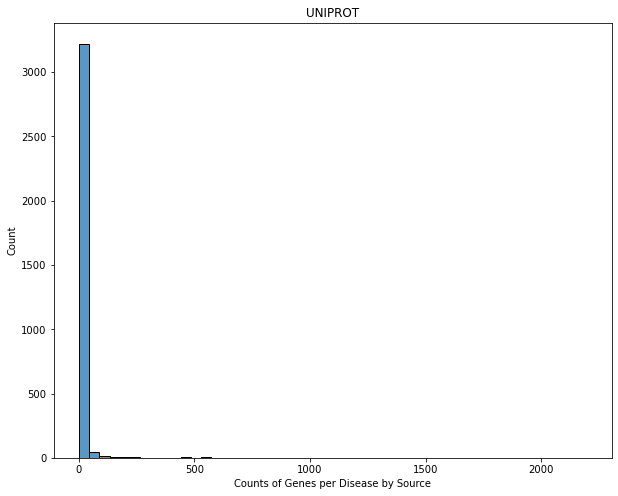

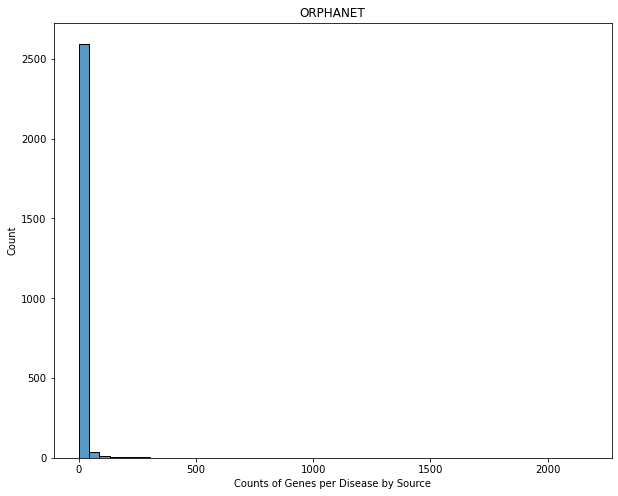

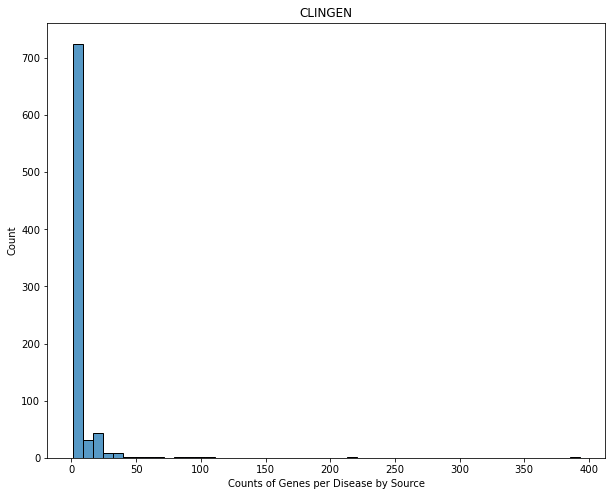

In [71]:
for i, source in enumerate(SumDisease.source.unique(), 1):
    data = SumDisease[SumDisease.source == source]
    fig, ax = plt.subplots(figsize = (10,8))
    sns.histplot(data['Counts of Genes per Disease by Source'], bins=50)
    plt.title(source)

## Find out all the disease terms that have ≥n_s genes (after propagation) from 3 different sources. Use n_s = 10 to begin with:

## Redo of this process:

In [72]:
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:3426,"{2299, 3766}",CLINGEN,vestibular disease
2,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN,sensory system disease
3,DOID:4,"{8192, 7168, 1027, 51204, 51206, 3081, 23568, ...",CLINGEN,disease
4,DOID:2952,"{2299, 3766}",CLINGEN,inner ear disease
...,...,...,...,...
44,DOID:809,"{4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...",PSYGENET,cocaine abuse
45,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET,subacute delirium
46,DOID:9478,"{8864, 6532, 3350, 4988, 50809, 4524, 148014}",PSYGENET,postpartum depression
47,DOID:9505,"{6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...",PSYGENET,cannabis abuse


In [73]:
templist = []
for index, row, in propagated.iterrows():
    templist.append(len(row['geneSet']))
propagated['numgenes_prop'] = templist
propagated

,DOID,geneSet,source,diseaseName,numgenes_prop
0,DOID:0050332,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct,2
1,DOID:3426,"{2299, 3766}",CLINGEN,vestibular disease,2
2,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN,sensory system disease,18
3,DOID:4,"{8192, 7168, 1027, 51204, 51206, 3081, 23568, ...",CLINGEN,disease,393
4,DOID:2952,"{2299, 3766}",CLINGEN,inner ear disease,2
...,...,...,...,...,...
44,DOID:809,"{4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...",PSYGENET,cocaine abuse,15
45,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET,subacute delirium,10
46,DOID:9478,"{8864, 6532, 3350, 4988, 50809, 4524, 148014}",PSYGENET,postpartum depression,7
47,DOID:9505,"{6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...",PSYGENET,cannabis abuse,20


In [74]:
tempdict = {}
for index, row, in propagated.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneSet']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneSet']})
tempdict

{'DOID:0050332': {2299, 3766, 5172},
 'DOID:3426': {476,
  1837,
  2299,
  2950,
  2954,
  3766,
  4846,
  5172,
  5579,
  83715,
  84530,
  84908,
  729330},
 'DOID:0050155': {18,
  24,
  38,
  43,
  60,
  70,
  71,
  107,
  116,
  135,
  147,
  183,
  185,
  196,
  210,
  213,
  218,
  220,
  231,
  249,
  317,
  328,
  348,
  351,
  384,
  403,
  411,
  471,
  472,
  476,
  490,
  491,
  501,
  525,
  538,
  582,
  583,
  585,
  590,
  596,
  598,
  611,
  627,
  629,
  631,
  650,
  652,
  686,
  717,
  718,
  726,
  735,
  755,
  762,
  773,
  774,
  777,
  778,
  794,
  836,
  842,
  847,
  857,
  858,
  875,
  885,
  1000,
  1001,
  1024,
  1029,
  1030,
  1103,
  1121,
  1123,
  1128,
  1136,
  1137,
  1138,
  1139,
  1143,
  1173,
  1191,
  1200,
  1201,
  1203,
  1244,
  1258,
  1259,
  1261,
  1268,
  1280,
  1282,
  1287,
  1296,
  1297,
  1298,
  1301,
  1302,
  1356,
  1392,
  1401,
  1406,
  1409,
  1410,
  1411,
  1412,
  1413,
  1414,
  1415,
  1417,
  1419,
  1420,
  

In [75]:
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneSet'])
df

,DOID,geneSet
0,DOID:0050332,"{2299, 5172, 3766}"
1,DOID:3426,"{83715, 2950, 2954, 5579, 84908, 1837, 4846, 8..."
2,DOID:0050155,"{8195, 100048912, 18, 4117, 24, 57369, 38, 43,..."
3,DOID:4,"{1, 2, 9, 10, 100499467, 12, 18, 19, 21, 22, 2..."
4,DOID:2952,"{1024, 83715, 25861, 4358, 1287, 146183, 23562..."
...,...,...
5255,DOID:0060166,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ..."
5256,DOID:10915,"{217, 125}"
5257,DOID:13487,"{2099, 811, 2950}"
5258,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347..."


In [76]:
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneSet']))
df['numgenes_prop'] = templist
df

,DOID,geneSet,numgenes_prop
0,DOID:0050332,"{2299, 5172, 3766}",3
1,DOID:3426,"{83715, 2950, 2954, 5579, 84908, 1837, 4846, 8...",13
2,DOID:0050155,"{8195, 100048912, 18, 4117, 24, 57369, 38, 43,...",839
3,DOID:4,"{1, 2, 9, 10, 100499467, 12, 18, 19, 21, 22, 2...",7974
4,DOID:2952,"{1024, 83715, 25861, 4358, 1287, 146183, 23562...",110
...,...,...,...
5255,DOID:0060166,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ...",17
5256,DOID:10915,"{217, 125}",2
5257,DOID:13487,"{2099, 811, 2950}",3
5258,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",10


In [77]:
propagatedafter5 = df.copy()

In [78]:
propagatedafter5

,DOID,geneSet,numgenes_prop
0,DOID:0050332,"{2299, 5172, 3766}",3
1,DOID:3426,"{83715, 2950, 2954, 5579, 84908, 1837, 4846, 8...",13
2,DOID:0050155,"{8195, 100048912, 18, 4117, 24, 57369, 38, 43,...",839
3,DOID:4,"{1, 2, 9, 10, 100499467, 12, 18, 19, 21, 22, 2...",7974
4,DOID:2952,"{1024, 83715, 25861, 4358, 1287, 146183, 23562...",110
...,...,...,...
5255,DOID:0060166,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ...",17
5256,DOID:10915,"{217, 125}",2
5257,DOID:13487,"{2099, 811, 2950}",3
5258,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",10


In [79]:
propagatedafter5.loc[propagatedafter5['DOID']=='DOID:0060041']

,DOID,geneSet,numgenes_prop
118,DOID:0060041,"{151556, 2053, 3077, 9228, 11281, 18, 5141, 51...",321


## Find out all the disease terms that have ≥n_d direct gene annotations (i.e., without propagation). Use n_d = 5 to begin with:

## Redo of this process:

In [80]:
resultDOID

,DOID,diseaseName,source,geneId
0,DOID:0001816,Hemangiosarcoma,CGI,"{5335, 5787, 3845, 3791}"
1,DOID:0001816,Hemangiosarcoma,CTD_human,"{1440, 3265, 4609, 7010, 7424, 3845, 2701, 372..."
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
4,DOID:0014667,Metabolic Diseases,CTD_human,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [81]:
tempdict = {}
for index, row, in resultDOID.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneId']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneId']})
tempdict

{'DOID:0001816': {285,
  595,
  1440,
  1499,
  2321,
  2701,
  3265,
  3725,
  3791,
  3845,
  4609,
  5335,
  5787,
  7010,
  7157,
  7422,
  7424,
  80781},
 'DOID:0002116': {3440, 23299},
 'DOID:0014667': {196, 1401, 1828, 2101, 2110, 3356, 3630, 5444, 5468, 51733},
 'DOID:0040084': {1673, 3576, 5594, 5595, 10747, 23411},
 'DOID:0040085': {133,
  135,
  136,
  284,
  836,
  1440,
  3146,
  3440,
  3458,
  3579,
  3586,
  3929,
  4049,
  4282,
  4318,
  4843,
  4846,
  5594,
  5595,
  5624,
  7040,
  7045,
  7099,
  7124},
 'DOID:0040099': {2147},
 'DOID:0050120': {331, 5551, 6813, 8676, 84868, 149041, 201294},
 'DOID:0050127': {563, 1080, 3596, 4233, 5304, 84687, 345895},
 'DOID:0050144': {1770,
  2302,
  2622,
  6103,
  6674,
  8481,
  10309,
  23639,
  25981,
  27019,
  27148,
  51364,
  54768,
  54919,
  55036,
  55130,
  56683,
  79925,
  83538,
  83861,
  85016,
  85478,
  89765,
  92749,
  93233,
  115399,
  115948,
  139212,
  161582,
  200373,
  246176,
  345643,
  352909,


In [82]:
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneId'])
df

,DOID,geneId
0,DOID:0001816,"{7424, 3265, 4609, 3845, 2701, 3725, 3791, 807..."
1,DOID:0002116,"{3440, 23299}"
2,DOID:0014667,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
3,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}"
4,DOID:0040085,"{7040, 3458, 3586, 133, 7045, 135, 136, 284, 1..."
...,...,...
4817,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4..."
4818,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255..."
4819,DOID:998,"{3123, 3117}"
4820,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}"


In [83]:
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneId']))
df['numgenes_dir'] = templist
df

,DOID,geneId,numgenes_dir
0,DOID:0001816,"{7424, 3265, 4609, 3845, 2701, 3725, 3791, 807...",18
1,DOID:0002116,"{3440, 23299}",2
2,DOID:0014667,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140...",10
3,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}",6
4,DOID:0040085,"{7040, 3458, 3586, 133, 7045, 135, 136, 284, 1...",24
...,...,...,...
4817,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4...",139
4818,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255...",9
4819,DOID:998,"{3123, 3117}",2
4820,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}",8


In [84]:
desired12before = df.copy()

In [85]:
desired12before

,DOID,geneId,numgenes_dir
0,DOID:0001816,"{7424, 3265, 4609, 3845, 2701, 3725, 3791, 807...",18
1,DOID:0002116,"{3440, 23299}",2
2,DOID:0014667,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140...",10
3,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}",6
4,DOID:0040085,"{7040, 3458, 3586, 133, 7045, 135, 136, 284, 1...",24
...,...,...,...
4817,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4...",139
4818,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255...",9
4819,DOID:998,"{3123, 3117}",2
4820,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}",8


## Merging Process:

In [86]:
propagatedafter5

,DOID,geneSet,numgenes_prop
0,DOID:0050332,"{2299, 5172, 3766}",3
1,DOID:3426,"{83715, 2950, 2954, 5579, 84908, 1837, 4846, 8...",13
2,DOID:0050155,"{8195, 100048912, 18, 4117, 24, 57369, 38, 43,...",839
3,DOID:4,"{1, 2, 9, 10, 100499467, 12, 18, 19, 21, 22, 2...",7974
4,DOID:2952,"{1024, 83715, 25861, 4358, 1287, 146183, 23562...",110
...,...,...,...
5255,DOID:0060166,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ...",17
5256,DOID:10915,"{217, 125}",2
5257,DOID:13487,"{2099, 811, 2950}",3
5258,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",10


In [87]:
desired12before

,DOID,geneId,numgenes_dir
0,DOID:0001816,"{7424, 3265, 4609, 3845, 2701, 3725, 3791, 807...",18
1,DOID:0002116,"{3440, 23299}",2
2,DOID:0014667,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140...",10
3,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}",6
4,DOID:0040085,"{7040, 3458, 3586, 133, 7045, 135, 136, 284, 1...",24
...,...,...,...
4817,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4...",139
4818,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255...",9
4819,DOID:998,"{3123, 3117}",2
4820,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}",8


In [88]:
desired12before.loc[desired12before['DOID']=='DOID:0060041']

,DOID,geneId,numgenes_dir
336,DOID:0060041,"{23040, 2562, 6660, 2053, 3077, 6662, 1804, 18...",85


In [89]:
mergedNew = propagatedafter5.merge(desired12before, how = 'inner')
mergedNew = mergedNew.drop(columns = ['geneSet', 'geneId'])
mergedNew

,DOID,numgenes_prop,numgenes_dir
0,DOID:0050332,3,3
1,DOID:3426,13,7
2,DOID:2952,110,7
3,DOID:2742,158,1
4,DOID:863,2206,53
...,...,...,...
4817,DOID:0080221,17,17
4818,DOID:10915,2,2
4819,DOID:13487,3,3
4820,DOID:8645,10,10


In [90]:
mergedNew.loc[mergedNew['DOID']=='DOID:0060041']

,DOID,numgenes_prop,numgenes_dir
81,DOID:0060041,321,85


In [91]:
propagated2 = propagated.drop(columns = 'numgenes_prop')
propagated2

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:3426,"{2299, 3766}",CLINGEN,vestibular disease
2,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN,sensory system disease
3,DOID:4,"{8192, 7168, 1027, 51204, 51206, 3081, 23568, ...",CLINGEN,disease
4,DOID:2952,"{2299, 3766}",CLINGEN,inner ear disease
...,...,...,...,...
44,DOID:809,"{4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...",PSYGENET,cocaine abuse
45,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET,subacute delirium
46,DOID:9478,"{8864, 6532, 3350, 4988, 50809, 4524, 148014}",PSYGENET,postpartum depression
47,DOID:9505,"{6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...",PSYGENET,cannabis abuse


In [92]:
propagated2.loc[propagated['DOID']=='DOID:0060041']

,DOID,geneSet,source,diseaseName
118,DOID:0060041,{57680},CLINGEN,autism spectrum disorder
98,DOID:0060041,"{151556, 2053, 3077, 9228, 11281, 18, 5141, 51...",CTD_human,autism spectrum disorder
90,DOID:0060041,"{23040, 50944, 9024, 4929, 7812, 55879, 7432, ...",GENOMICS_ENGLAND,autism spectrum disorder


In [93]:
test = mergedNew.merge(propagated2)
test

,DOID,numgenes_prop,numgenes_dir,geneSet,source,diseaseName
0,DOID:0050332,3,3,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:0050332,3,3,{5172},GENOMICS_ENGLAND,enlarged vestibular aqueduct
2,DOID:3426,13,7,"{2299, 3766}",CLINGEN,vestibular disease
3,DOID:3426,13,7,"{84530, 83715, 729330, 2950, 2954, 476, 4846}",CTD_human,vestibular disease
4,DOID:3426,13,7,"{5172, 5579, 84908, 1837}",GENOMICS_ENGLAND,vestibular disease
...,...,...,...,...,...,...
14457,DOID:0080221,17,17,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ...",PSYGENET,major affective disorder 2
14458,DOID:10915,2,2,"{217, 125}",PSYGENET,Wernicke-Korsakoff syndrome
14459,DOID:13487,3,3,"{2099, 811, 2950}",PSYGENET,childhood disintegrative disease
14460,DOID:8645,10,10,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET,subacute delirium


In [94]:
test.loc[test['DOID']=='DOID:0060041']

,DOID,numgenes_prop,numgenes_dir,geneSet,source,diseaseName
401,DOID:0060041,321,85,{57680},CLINGEN,autism spectrum disorder
402,DOID:0060041,321,85,"{151556, 2053, 3077, 9228, 11281, 18, 5141, 51...",CTD_human,autism spectrum disorder
403,DOID:0060041,321,85,"{23040, 50944, 9024, 4929, 7812, 55879, 7432, ...",GENOMICS_ENGLAND,autism spectrum disorder


In [95]:
mergedNew2 = test.rename(columns = {'DOID': 'dis_doid', 'diseaseName': 'dis_name'})
mergedNew2 = mergedNew2[['dis_doid', 'dis_name', 'source', 'numgenes_prop', 'numgenes_dir', 'geneSet']]
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet
0,DOID:0050332,enlarged vestibular aqueduct,CLINGEN,3,3,"{2299, 3766}"
1,DOID:0050332,enlarged vestibular aqueduct,GENOMICS_ENGLAND,3,3,{5172}
2,DOID:3426,vestibular disease,CLINGEN,13,7,"{2299, 3766}"
3,DOID:3426,vestibular disease,CTD_human,13,7,"{84530, 83715, 729330, 2950, 2954, 476, 4846}"
4,DOID:3426,vestibular disease,GENOMICS_ENGLAND,13,7,"{5172, 5579, 84908, 1837}"
...,...,...,...,...,...,...
14457,DOID:0080221,major affective disorder 2,PSYGENET,17,17,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ..."
14458,DOID:10915,Wernicke-Korsakoff syndrome,PSYGENET,2,2,"{217, 125}"
14459,DOID:13487,childhood disintegrative disease,PSYGENET,3,3,"{2099, 811, 2950}"
14460,DOID:8645,subacute delirium,PSYGENET,10,10,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347..."


In [96]:
mergedNew2.loc[mergedNew2['dis_doid']=='DOID:0060041']

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet
401,DOID:0060041,autism spectrum disorder,CLINGEN,321,85,{57680}
402,DOID:0060041,autism spectrum disorder,CTD_human,321,85,"{151556, 2053, 3077, 9228, 11281, 18, 5141, 51..."
403,DOID:0060041,autism spectrum disorder,GENOMICS_ENGLAND,321,85,"{23040, 50944, 9024, 4929, 7812, 55879, 7432, ..."


In [97]:
mergedNew2['numgenes_CLINGEN'] = np.NaN
mergedNew2['numgenes_CGI'] = np.NaN
mergedNew2['numgenes_CTD_human'] = np.NaN
mergedNew2['numgenes_GENOMICS_ENGLAND'] = np.NaN
mergedNew2['numgenes_ORPHANET'] = np.NaN
mergedNew2['numgenes_PSYGENET'] = np.NaN
mergedNew2['numgenes_UNIPROT'] = np.NaN
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050332,enlarged vestibular aqueduct,CLINGEN,3,3,"{2299, 3766}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DOID:0050332,enlarged vestibular aqueduct,GENOMICS_ENGLAND,3,3,{5172},NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DOID:3426,vestibular disease,CLINGEN,13,7,"{2299, 3766}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DOID:3426,vestibular disease,CTD_human,13,7,"{84530, 83715, 729330, 2950, 2954, 476, 4846}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DOID:3426,vestibular disease,GENOMICS_ENGLAND,13,7,"{5172, 5579, 84908, 1837}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14457,DOID:0080221,major affective disorder 2,PSYGENET,17,17,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14458,DOID:10915,Wernicke-Korsakoff syndrome,PSYGENET,2,2,"{217, 125}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14459,DOID:13487,childhood disintegrative disease,PSYGENET,3,3,"{2099, 811, 2950}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14460,DOID:8645,subacute delirium,PSYGENET,10,10,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'CLINGEN'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_CLINGEN'] = templist
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050332,enlarged vestibular aqueduct,CLINGEN,3,3,"{2299, 3766}",2,NaN,NaN,NaN,NaN,NaN,NaN
1,DOID:0050332,enlarged vestibular aqueduct,GENOMICS_ENGLAND,3,3,{5172},0,NaN,NaN,NaN,NaN,NaN,NaN
2,DOID:3426,vestibular disease,CLINGEN,13,7,"{2299, 3766}",2,NaN,NaN,NaN,NaN,NaN,NaN
3,DOID:3426,vestibular disease,CTD_human,13,7,"{84530, 83715, 729330, 2950, 2954, 476, 4846}",0,NaN,NaN,NaN,NaN,NaN,NaN
4,DOID:3426,vestibular disease,GENOMICS_ENGLAND,13,7,"{5172, 5579, 84908, 1837}",0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14457,DOID:0080221,major affective disorder 2,PSYGENET,17,17,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ...",0,NaN,NaN,NaN,NaN,NaN,NaN
14458,DOID:10915,Wernicke-Korsakoff syndrome,PSYGENET,2,2,"{217, 125}",0,NaN,NaN,NaN,NaN,NaN,NaN
14459,DOID:13487,childhood disintegrative disease,PSYGENET,3,3,"{2099, 811, 2950}",0,NaN,NaN,NaN,NaN,NaN,NaN
14460,DOID:8645,subacute delirium,PSYGENET,10,10,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",0,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'CGI'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_CGI'] = templist

In [100]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'PSYGENET'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_PSYGENET'] = templist

In [101]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'CTD_human'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_CTD_human'] = templist

In [102]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'GENOMICS_ENGLAND'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_GENOMICS_ENGLAND'] = templist

In [103]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'ORPHANET'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_ORPHANET'] = templist

In [104]:
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'UNIPROT'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_UNIPROT'] = templist

In [105]:
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050332,enlarged vestibular aqueduct,CLINGEN,3,3,"{2299, 3766}",2,0,0,0,0,0,0
1,DOID:0050332,enlarged vestibular aqueduct,GENOMICS_ENGLAND,3,3,{5172},0,0,0,1,0,0,0
2,DOID:3426,vestibular disease,CLINGEN,13,7,"{2299, 3766}",2,0,0,0,0,0,0
3,DOID:3426,vestibular disease,CTD_human,13,7,"{84530, 83715, 729330, 2950, 2954, 476, 4846}",0,0,7,0,0,0,0
4,DOID:3426,vestibular disease,GENOMICS_ENGLAND,13,7,"{5172, 5579, 84908, 1837}",0,0,0,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14457,DOID:0080221,major affective disorder 2,PSYGENET,17,17,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ...",0,0,0,0,0,17,0
14458,DOID:10915,Wernicke-Korsakoff syndrome,PSYGENET,2,2,"{217, 125}",0,0,0,0,0,2,0
14459,DOID:13487,childhood disintegrative disease,PSYGENET,3,3,"{2099, 811, 2950}",0,0,0,0,0,3,0
14460,DOID:8645,subacute delirium,PSYGENET,10,10,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",0,0,0,0,0,10,0


In [106]:
ArjunData = mergedNew2[['dis_doid', 'dis_name','numgenes_CLINGEN', 'numgenes_CGI', 'numgenes_CTD_human',
       'numgenes_GENOMICS_ENGLAND', 'numgenes_ORPHANET', 'numgenes_PSYGENET',
       'numgenes_UNIPROT', 'numgenes_dir', 'numgenes_prop']]
ArjunData

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:0050332,enlarged vestibular aqueduct,2,0,0,0,0,0,0,3,3
1,DOID:0050332,enlarged vestibular aqueduct,0,0,0,1,0,0,0,3,3
2,DOID:3426,vestibular disease,2,0,0,0,0,0,0,7,13
3,DOID:3426,vestibular disease,0,0,7,0,0,0,0,7,13
4,DOID:3426,vestibular disease,0,0,0,4,0,0,0,7,13
...,...,...,...,...,...,...,...,...,...,...,...
14457,DOID:0080221,major affective disorder 2,0,0,0,0,0,17,0,17,17
14458,DOID:10915,Wernicke-Korsakoff syndrome,0,0,0,0,0,2,0,2,2
14459,DOID:13487,childhood disintegrative disease,0,0,0,0,0,3,0,3,3
14460,DOID:8645,subacute delirium,0,0,0,0,0,10,0,10,10


In [107]:
ArjunData2 = ArjunData.groupby(['dis_doid', 'dis_name', 'numgenes_dir', 'numgenes_prop']).sum()
ArjunData2

,,,,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
dis_doid,dis_name,numgenes_dir,numgenes_prop,,,,,,,
DOID:0001816,angiosarcoma,18,18,0,4,18,0,0,0,0
DOID:0002116,pterygium,2,2,0,0,1,1,0,0,0
DOID:0014667,disease of metabolism,10,1109,88,1,943,413,253,2,252
DOID:0040084,Streptococcus pneumonia,6,6,0,0,6,0,0,0,0
DOID:0040085,bacterial sepsis,24,24,0,0,24,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
DOID:9975,cocaine dependence,139,139,0,0,117,0,0,36,0
DOID:9976,heroin dependence,9,9,0,0,9,0,0,0,0
DOID:998,eosinophilia-myalgia syndrome,2,2,0,0,2,0,0,0,0


In [108]:
ArjunData2 = ArjunData2.reset_index()
ArjunData2

,dis_doid,dis_name,numgenes_dir,numgenes_prop,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0001816,angiosarcoma,18,18,0,4,18,0,0,0,0
1,DOID:0002116,pterygium,2,2,0,0,1,1,0,0,0
2,DOID:0014667,disease of metabolism,10,1109,88,1,943,413,253,2,252
3,DOID:0040084,Streptococcus pneumonia,6,6,0,0,6,0,0,0,0
4,DOID:0040085,bacterial sepsis,24,24,0,0,24,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4817,DOID:9975,cocaine dependence,139,139,0,0,117,0,0,36,0
4818,DOID:9976,heroin dependence,9,9,0,0,9,0,0,0,0
4819,DOID:998,eosinophilia-myalgia syndrome,2,2,0,0,2,0,0,0,0
4820,DOID:999,hypereosinophilic syndrome,8,14,0,2,11,2,0,0,0


In [109]:
ArjunData2 = ArjunData2.sort_values(by = 'numgenes_prop', ascending = False)
ArjunData2

,dis_doid,dis_name,numgenes_dir,numgenes_prop,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
3668,DOID:162,cancer,128,3574,32,307,2963,168,247,0,740
4632,DOID:863,nervous system disease,53,2206,37,47,1657,974,601,0,553
3641,DOID:150,disease of mental health,12,2069,21,0,955,433,92,1132,72
4558,DOID:77,gastrointestinal system disease,12,1987,5,71,1433,162,76,0,553
3968,DOID:3119,gastrointestinal system cancer,6,1463,3,76,993,29,17,0,528
...,...,...,...,...,...,...,...,...,...,...,...
2925,DOID:0111367,error,1,1,0,0,1,1,1,0,1
2928,DOID:0111370,error,1,1,0,0,1,0,0,0,1
2929,DOID:0111371,error,1,1,0,0,1,0,1,0,1
2930,DOID:0111372,error,1,1,0,0,1,1,1,0,1


In [110]:
ArjunData2 = ArjunData2[['dis_doid', 'dis_name','numgenes_CLINGEN', 'numgenes_CGI', 'numgenes_CTD_human',
       'numgenes_GENOMICS_ENGLAND', 'numgenes_ORPHANET', 'numgenes_PSYGENET',
       'numgenes_UNIPROT', 'numgenes_dir', 'numgenes_prop']]
ArjunData2

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
3668,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574
4632,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206
3641,DOID:150,disease of mental health,21,0,955,433,92,1132,72,12,2069
4558,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987
3968,DOID:3119,gastrointestinal system cancer,3,76,993,29,17,0,528,6,1463
...,...,...,...,...,...,...,...,...,...,...,...
2925,DOID:0111367,error,0,0,1,1,1,0,1,1,1
2928,DOID:0111370,error,0,0,1,0,0,0,1,1,1
2929,DOID:0111371,error,0,0,1,0,1,0,1,1,1
2930,DOID:0111372,error,0,0,1,1,1,0,1,1,1


In [111]:
ArjunData2.loc[ArjunData2['dis_doid']=='DOID:0060041']

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
336,DOID:0060041,autism spectrum disorder,1,0,303,26,0,0,0,85,321


In [112]:
ArjunData2.to_csv('DesiredDataArjunAllDisease.tsv', index = False, sep = "\t")

In [113]:
trial = pd.read_csv('DesiredDataArjunAllDisease.tsv', sep = "\t")
trial

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574
1,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206
2,DOID:150,disease of mental health,21,0,955,433,92,1132,72,12,2069
3,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987
4,DOID:3119,gastrointestinal system cancer,3,76,993,29,17,0,528,6,1463
...,...,...,...,...,...,...,...,...,...,...,...
4817,DOID:0111367,error,0,0,1,1,1,0,1,1,1
4818,DOID:0111370,error,0,0,1,0,0,0,1,1,1
4819,DOID:0111371,error,0,0,1,0,1,0,1,1,1
4820,DOID:0111372,error,0,0,1,1,1,0,1,1,1


In [3]:
ArjunData2 = pd.read_csv('DesiredDataArjun.tsv', sep = '\t')
ArjunData2

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:936,brain disease,15,32,747,320,156,0,118,27,1034
1,DOID:5295,intestinal disease,1,55,532,104,7,0,476,8,1026
2,DOID:850,lung disease,1,42,771,53,23,0,109,78,895
3,DOID:10155,intestinal cancer,0,55,406,20,0,0,468,12,846
4,DOID:5672,large intestine cancer,0,54,401,19,0,0,468,878,840
...,...,...,...,...,...,...,...,...,...,...,...
503,DOID:0060854,autosomal recessive pseudohypoaldosteronism ty...,0,0,10,3,3,0,2,10,10
504,DOID:0060855,autosomal dominant pseudohypoaldosteronism type 1,0,0,10,3,3,0,2,10,10
505,DOID:12932,endomyocardial fibrosis,0,0,9,1,1,0,1,13,10
506,DOID:0090043,dystonia 5,0,0,7,3,1,0,1,10,10


In [6]:
templist = []
for index, row, in ArjunData2.iterrows():
    tempcount = 0
    if (row['numgenes_CLINGEN'] >= 10):
        tempcount += 1
    if (row['numgenes_CGI'] >= 10):
        tempcount += 1
    if (row['numgenes_CTD_human'] >= 10):
        tempcount += 1
    if (row['numgenes_GENOMICS_ENGLAND'] >= 10):
        tempcount += 1
    if (row['numgenes_ORPHANET'] >= 10):
        tempcount += 1
    if (row['numgenes_PSYGENET'] >= 10):
        tempcount += 1
    if (row['numgenes_UNIPROT'] >= 10):
        tempcount += 1
    else:
        tempcount += 0
    templist.append(tempcount)
ArjunData2['tempcounts'] = templist

In [7]:
ArjunData2

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,tempcounts
0,DOID:936,brain disease,15,32,747,320,156,0,118,27,1034,6
1,DOID:5295,intestinal disease,1,55,532,104,7,0,476,8,1026,4
2,DOID:850,lung disease,1,42,771,53,23,0,109,78,895,5
3,DOID:10155,intestinal cancer,0,55,406,20,0,0,468,12,846,4
4,DOID:5672,large intestine cancer,0,54,401,19,0,0,468,878,840,4
...,...,...,...,...,...,...,...,...,...,...,...,...
503,DOID:0060854,autosomal recessive pseudohypoaldosteronism ty...,0,0,10,3,3,0,2,10,10,1
504,DOID:0060855,autosomal dominant pseudohypoaldosteronism type 1,0,0,10,3,3,0,2,10,10,1
505,DOID:12932,endomyocardial fibrosis,0,0,9,1,1,0,1,13,10,0
506,DOID:0090043,dystonia 5,0,0,7,3,1,0,1,10,10,0


In [9]:
ArjunData3 = ArjunData2[ArjunData2['tempcounts'].map(lambda d: d) >= 3]
ArjunData3

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,tempcounts
0,DOID:936,brain disease,15,32,747,320,156,0,118,27,1034,6
1,DOID:5295,intestinal disease,1,55,532,104,7,0,476,8,1026,4
2,DOID:850,lung disease,1,42,771,53,23,0,109,78,895,5
3,DOID:10155,intestinal cancer,0,55,406,20,0,0,468,12,846,4
4,DOID:5672,large intestine cancer,0,54,401,19,0,0,468,878,840,4
...,...,...,...,...,...,...,...,...,...,...,...,...
326,DOID:4254,osteosclerosis,0,0,15,14,10,0,9,7,18,3
328,DOID:4621,holoprosencephaly,0,0,11,14,14,0,7,17,18,3
396,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14,3
407,DOID:8499,night blindness,0,0,14,12,2,0,11,7,14,3


In [11]:
ArjunData3 = ArjunData3.drop(columns = 'tempcounts')
ArjunData3

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:936,brain disease,15,32,747,320,156,0,118,27,1034
1,DOID:5295,intestinal disease,1,55,532,104,7,0,476,8,1026
2,DOID:850,lung disease,1,42,771,53,23,0,109,78,895
3,DOID:10155,intestinal cancer,0,55,406,20,0,0,468,12,846
4,DOID:5672,large intestine cancer,0,54,401,19,0,0,468,878,840
...,...,...,...,...,...,...,...,...,...,...,...
326,DOID:4254,osteosclerosis,0,0,15,14,10,0,9,7,18
328,DOID:4621,holoprosencephaly,0,0,11,14,14,0,7,17,18
396,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14
407,DOID:8499,night blindness,0,0,14,12,2,0,11,7,14


In [12]:
ArjunData3.to_csv('DesiredDataArjun.tsv', index = False, sep = "\t")